# Import modules

In [1]:
import gdal
import shapefile
from osgeo import osr
import glob
from scipy import interpolate
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
floodmap=gdal.Open('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/CombinedOutput_FloodMap/NOR_Fluvial_100yr.tif')

In [3]:
arr = floodmap.ReadAsArray()

In [4]:
proj_wkt = floodmap.GetProjection()


In [5]:
proj = osr.SpatialReference()
proj.ImportFromWkt(proj_wkt)


0

In [6]:
geo_transform = floodmap.GetGeoTransform()

In [7]:
origin_x = geo_transform[0]
origin_y = geo_transform[3]
pixel_width = geo_transform[1]
pixel_height = geo_transform[5]
n_cols = floodmap.RasterXSize
n_rows = floodmap.RasterYSize
n_cols, n_rows

(23712, 29062)

In [8]:
band = floodmap.GetRasterBand(1)
gdal.GetDataTypeName(band.DataType)

'Float32'

In [9]:
extent_lonlat = (
    origin_x, 
    origin_x + (pixel_width * floodmap.RasterXSize),
    origin_y + (pixel_height * floodmap.RasterYSize),
    origin_y
)

## Idea 3
* Read in shapefile
* Match points and tangent to image
* plot difference across boundary

In [10]:
def find_nearest(array, value):
    ''' Find nearest value is an array '''
    idx=np.empty((value.size))
    for i in range(0,value.size):
        idx[i] = (np.abs(array-value[i])).argmin()
    return idx.astype('int')

In [29]:
sfiles=glob.glob('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/Domains/*.shp')

In [ ]:
df=[]
for ii, s in enumerate(sfiles):
    sf = shapefile.Reader(s)
    sh_points=np.array(sf.shapes()[0].points)
    xpix=np.arange(extent_lonlat[0],extent_lonlat[1],pixel_width)
    ypix=np.arange(extent_lonlat[3],extent_lonlat[2],pixel_height)
    
# loop over shape points
    points=np.ones((5000,3))
    c=0
    pix_dist=np.array([1,5])

    for i in range(0,sh_points.shape[0]-1):        
        #need to interpolate between points in shapefile
        fx = interpolate.interp1d(sh_points[i:i+2,0],sh_points[i:i+2,1],kind='slinear',fill_value='extrapolate')
        if sh_points[i,0]<sh_points[i+1,0]:
            xnew=np.arange(sh_points[i,0],sh_points[i+1,0],pixel_width)
        else:
            xnew=np.arange(sh_points[i,0],sh_points[i+1,0],-pixel_width)
        ynew=fx(xnew)
        fy=interpolate.interp1d(sh_points[i:i+2,1],sh_points[i:i+2,0],kind='slinear',fill_value='extrapolate')
        if sh_points[i,1]>sh_points[i+1,1]:
            ynew_2=np.arange(sh_points[i,1],sh_points[i+1,1],pixel_height)
        else:
            ynew_2=np.arange(sh_points[i,1],sh_points[i+1,1],-pixel_height)
        xnew_2=fy(ynew_2)
        
        for j in range(xnew.shape[0]-1):
            try:
                #calculate difference in x and y for tangent
                dy=ynew[j+1]-ynew[j]
                dx=xnew[j+1]-xnew[j]
                angle=0.5*np.pi-np.arctan(dy/dx)
                t_x=pix_dist*pixel_width*np.cos(angle)#ideally should be 0.5*pixel but more stable if 1.1
                t_y=pix_dist*pixel_height*np.sin(angle)
                #inner value
                x_in=find_nearest(xpix,xnew[j]+t_x)
                y_in=find_nearest(ypix,ynew[j]+t_y)
                #outer value
                x_out=find_nearest(xpix,xnew[j]-t_x)
                y_out=find_nearest(ypix,ynew[j]-t_y)
            
                points[c,:]=[(np.max(arr[y_out,x_out])-np.max(arr[y_in,x_in]))/dx,xnew[j],ynew[j]]
                c+=1
            except(IndexError):
                print('issue')
        for j in range(xnew_2.shape[0]-1):
            #calculate difference in x and y for tangent
            dy=ynew_2[j+1]-ynew_2[j]
            dx=xnew_2[j+1]-xnew_2[j]
            angle=0.5*np.pi-np.arctan(dy/dx)
            t_x=pix_dist*pixel_width*np.cos(angle)#ideally should be 0.5*pixel but more stable if 1.1
            t_y=pix_dist*pixel_height*np.sin(angle)
            #inner value
            x_in=find_nearest(xpix,xnew_2[j]+t_x)
            y_in=find_nearest(ypix,ynew_2[j]+t_y)
        
            #outer value
            x_out=find_nearest(xpix,xnew_2[j]-t_x)
            y_out=find_nearest(ypix,ynew_2[j]-t_y)
            points[c,:]=[(np.max(arr[y_out,x_out])-np.max(arr[y_in,x_in]))/dx,xnew_2[j],ynew_2[j]]
            c+=1
    ind=points[:,0]<-100.0
    if ind.sum()>0:
        db = DBSCAN(eps=pixel_width*5, min_samples=10).fit(points[ind,1:3])
        labels = db.labels_
        ind_keep=labels>=0
        data = {'Domain': s.split('/')[-1] * ind_keep.sum(),
        'lat': points[ind,2][ind_keep],
        'lon': points[ind,1][ind_keep]}

        df.append(pd.DataFrame(data))
    print('Domain ',s.split('/')[-1], ii,len(sfiles))
alldf = pd.concat(df)
geometry = [Point(xy) for xy in zip(alldf['lon'],alldf['lat'])]
gdf = GeoDataFrame(alldf, geometry=geometry)
gdf.to_file(filename='./final_solution')

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1000_1_Domain.shp 0 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1001_1_Domain.shp 1 5151
Domain  NOR_1002_1_Domain.shp 2 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1003_1_Domain.shp 3 5151
Domain  NOR_1004_1_Domain.shp 4 5151
Domain  NOR_1005_1_Domain.shp 5 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1006_1_Domain.shp 6 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1007_1_Domain.shp 7 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1008_1_Domain.shp 8 5151
Domain  NOR_1009_1_Domain.shp 9 5151
Domain  NOR_100_1_Domain.shp 10 5151
Domain  NOR_1010_1_Domain.shp 11 5151
Domain  NOR_1011_1_Domain.shp 12 5151
Domain  NOR_1012_1_Domain.shp 13 5151
Domain  NOR_1013_1_Domain.shp 14 5151
Domain  NOR_1014_1_Domain.shp 15 5151
Domain  NOR_1015_1_Domain.shp 16 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1016_1_Domain.shp 17 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1017_1_Domain.shp 18 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1018_1_Domain.shp 19 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1019_1_Domain.shp 20 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_101_1_Domain.shp 21 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1020_1_Domain.shp 22 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1021_1_Domain.shp 23 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1022_1_Domain.shp 24 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1023_1_Domain.shp 25 5151
Domain  NOR_1024_1_Domain.shp 26 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1025_1_Domain.shp 27 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1026_1_Domain.shp 28 5151
Domain  NOR_1027_1_Domain.shp 29 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1028_1_Domain.shp 30 5151
Domain  NOR_1029_1_Domain.shp 31 5151
Domain  NOR_102_1_Domain.shp 32 5151
Domain  NOR_1030_1_Domain.shp 33 5151
Domain  NOR_1031_1_Domain.shp 34 5151
Domain  NOR_1032_1_Domain.shp 35 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1033_1_Domain.shp 36 5151
Domain  NOR_1034_1_Domain.shp 37 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1035_1_Domain.shp 38 5151
Domain  NOR_1036_1_Domain.shp 39 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1037_1_Domain.shp 40 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1038_1_Domain.shp 41 5151
Domain  NOR_1039_1_Domain.shp 42 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_103_1_Domain.shp 43 5151
Domain  NOR_1040_1_Domain.shp 44 5151
Domain  NOR_1041_1_Domain.shp 45 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1042_1_Domain.shp 46 5151
Domain  NOR_1043_1_Domain.shp 47 5151
Domain  NOR_1044_1_Domain.shp 48 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1045_1_Domain.shp 49 5151
Domain  NOR_1046_1_Domain.shp 50 5151
Domain  NOR_1047_1_Domain.shp 51 5151
Domain  NOR_1048_1_Domain.shp 52 5151
Domain  NOR_1049_1_Domain.shp 53 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_104_1_Domain.shp 54 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1050_1_Domain.shp 55 5151
Domain  NOR_1051_1_Domain.shp 56 5151
Domain  NOR_1052_1_Domain.shp 57 5151
Domain  NOR_1053_1_Domain.shp 58 5151
Domain  NOR_1054_1_Domain.shp 59 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1055_1_Domain.shp 60 5151
Domain  NOR_1056_1_Domain.shp 61 5151
Domain  NOR_1057_1_Domain.shp 62 5151
Domain  NOR_1058_1_Domain.shp 63 5151
Domain  NOR_1059_1_Domain.shp 64 5151
Domain  NOR_105_1_Domain.shp 65 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1060_1_Domain.shp 66 5151
Domain  NOR_1061_1_Domain.shp 67 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1062_1_Domain.shp 68 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1063_1_Domain.shp 69 5151
Domain  NOR_1064_1_Domain.shp 70 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1065_1_Domain.shp 71 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1066_1_Domain.shp 72 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1067_1_Domain.shp 73 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1068_1_Domain.shp 74 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1069_1_Domain.shp 75 5151
Domain  NOR_106_1_Domain.shp 76 5151
Domain  NOR_1070_1_Domain.shp 77 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1071_1_Domain.shp 78 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1072_1_Domain.shp 79 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1073_1_Domain.shp 80 5151
Domain  NOR_1074_1_Domain.shp 81 5151
Domain  NOR_1075_1_Domain.shp 82 5151
Domain  NOR_1076_1_Domain.shp 83 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1077_1_Domain.shp 84 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1078_1_Domain.shp 85 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1079_1_Domain.shp 86 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_107_1_Domain.shp 87 5151
Domain  NOR_1080_1_Domain.shp 88 5151
Domain  NOR_1081_1_Domain.shp 89 5151
Domain  NOR_1082_1_Domain.shp 90 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1083_1_Domain.shp 91 5151
Domain  NOR_1084_1_Domain.shp 92 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1085_1_Domain.shp 93 5151
Domain  NOR_1086_1_Domain.shp 94 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1087_1_Domain.shp 95 5151
Domain  NOR_1088_1_Domain.shp 96 5151
Domain  NOR_1089_1_Domain.shp 97 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_108_1_Domain.shp 98 5151
Domain  NOR_1090_1_Domain.shp 99 5151
Domain  NOR_1091_1_Domain.shp 100 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1092_1_Domain.shp 101 5151
Domain  NOR_1093_1_Domain.shp 102 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1094_1_Domain.shp 103 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1095_1_Domain.shp 104 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1096_1_Domain.shp 105 5151
Domain  NOR_1097_1_Domain.shp 106 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1098_1_Domain.shp 107 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1099_1_Domain.shp 108 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_109_1_Domain.shp 109 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_10_1_Domain.shp 110 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1100_1_Domain.shp 111 5151
Domain  NOR_1101_1_Domain.shp 112 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1102_1_Domain.shp 113 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1103_1_Domain.shp 114 5151
Domain  NOR_1104_1_Domain.shp 115 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1105_1_Domain.shp 116 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1106_1_Domain.shp 117 5151
Domain  NOR_1107_1_Domain.shp 118 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1108_1_Domain.shp 119 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1109_1_Domain.shp 120 5151
Domain  NOR_110_1_Domain.shp 121 5151
Domain  NOR_1110_1_Domain.shp 122 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1111_1_Domain.shp 123 5151
Domain  NOR_1112_1_Domain.shp 124 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1113_1_Domain.shp 125 5151
Domain  NOR_1114_1_Domain.shp 126 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1115_1_Domain.shp 127 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1116_1_Domain.shp 128 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1117_1_Domain.shp 129 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1118_1_Domain.shp 130 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1119_1_Domain.shp 131 5151
Domain  NOR_111_1_Domain.shp 132 5151
Domain  NOR_1120_1_Domain.shp 133 5151
Domain  NOR_1121_1_Domain.shp 134 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1122_1_Domain.shp 135 5151
Domain  NOR_1123_1_Domain.shp 136 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1124_1_Domain.shp 137 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1125_1_Domain.shp 138 5151
Domain  NOR_1126_1_Domain.shp 139 5151
Domain  NOR_1127_1_Domain.shp 140 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1128_1_Domain.shp 141 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1129_1_Domain.shp 142 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_112_1_Domain.shp 143 5151
Domain  NOR_1130_1_Domain.shp 144 5151
Domain  NOR_1131_1_Domain.shp 145 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1132_1_Domain.shp 146 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1133_1_Domain.shp 147 5151
Domain  NOR_1134_1_Domain.shp 148 5151
Domain  NOR_1135_1_Domain.shp 149 5151
Domain  NOR_1136_1_Domain.shp 150 5151
Domain  NOR_1137_1_Domain.shp 151 5151
Domain  NOR_1138_1_Domain.shp 152 5151
Domain  NOR_1139_1_Domain.shp 153 5151
Domain  NOR_113_1_Domain.shp 154 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1140_1_Domain.shp 155 5151
Domain  NOR_1141_1_Domain.shp 156 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1142_1_Domain.shp 157 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1143_1_Domain.shp 158 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1144_1_Domain.shp 159 5151
Domain  NOR_1145_1_Domain.shp 160 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1146_1_Domain.shp 161 5151
Domain  NOR_1147_1_Domain.shp 162 5151
Domain  NOR_1148_1_Domain.shp 163 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1149_1_Domain.shp 164 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_114_1_Domain.shp 165 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1150_1_Domain.shp 166 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1151_1_Domain.shp 167 5151
Domain  NOR_1152_1_Domain.shp 168 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1153_1_Domain.shp 169 5151
Domain  NOR_1154_1_Domain.shp 170 5151
Domain  NOR_1155_1_Domain.shp 171 5151
Domain  NOR_1156_1_Domain.shp 172 5151
Domain  NOR_1157_1_Domain.shp 173 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1158_1_Domain.shp 174 5151
Domain  NOR_1159_1_Domain.shp 175 5151
Domain  NOR_115_1_Domain.shp 176 5151
Domain  NOR_1160_1_Domain.shp 177 5151
Domain  NOR_1161_1_Domain.shp 178 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1162_1_Domain.shp 179 5151
Domain  NOR_1163_1_Domain.shp 180 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1164_1_Domain.shp 181 5151
Domain  NOR_1165_1_Domain.shp 182 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1166_1_Domain.shp 183 5151
Domain  NOR_1167_1_Domain.shp 184 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1168_1_Domain.shp 185 5151
Domain  NOR_1169_1_Domain.shp 186 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_116_1_Domain.shp 187 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1170_1_Domain.shp 188 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1171_1_Domain.shp 189 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1172_1_Domain.shp 190 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1173_1_Domain.shp 191 5151
Domain  NOR_1174_1_Domain.shp 192 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1175_1_Domain.shp 193 5151
Domain  NOR_1176_1_Domain.shp 194 5151
Domain  NOR_1177_1_Domain.shp 195 5151
Domain  NOR_1178_1_Domain.shp 196 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1179_1_Domain.shp 197 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_117_1_Domain.shp 198 5151
Domain  NOR_1180_1_Domain.shp 199 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1181_1_Domain.shp 200 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1182_1_Domain.shp 201 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1183_1_Domain.shp 202 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1184_1_Domain.shp 203 5151
Domain  NOR_1185_1_Domain.shp 204 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1186_1_Domain.shp 205 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1187_1_Domain.shp 206 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1188_1_Domain.shp 207 5151
Domain  NOR_1189_1_Domain.shp 208 5151
Domain  NOR_118_1_Domain.shp 209 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1190_1_Domain.shp 210 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1191_1_Domain.shp 211 5151
Domain  NOR_1192_1_Domain.shp 212 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1193_1_Domain.shp 213 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1194_1_Domain.shp 214 5151
Domain  NOR_1195_1_Domain.shp 215 5151
Domain  NOR_1196_1_Domain.shp 216 5151
Domain  NOR_1197_1_Domain.shp 217 5151
Domain  NOR_1198_1_Domain.shp 218 5151
Domain  NOR_1199_1_Domain.shp 219 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_119_1_Domain.shp 220 5151
Domain  NOR_11_1_Domain.shp 221 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1200_1_Domain.shp 222 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1201_1_Domain.shp 223 5151
Domain  NOR_1202_1_Domain.shp 224 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1203_1_Domain.shp 225 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1204_1_Domain.shp 226 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1205_1_Domain.shp 227 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1206_1_Domain.shp 228 5151
Domain  NOR_1207_1_Domain.shp 229 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1208_1_Domain.shp 230 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1209_1_Domain.shp 231 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_120_1_Domain.shp 232 5151
Domain  NOR_1210_1_Domain.shp 233 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1211_1_Domain.shp 234 5151
Domain  NOR_1212_1_Domain.shp 235 5151
Domain  NOR_1213_1_Domain.shp 236 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1214_1_Domain.shp 237 5151
Domain  NOR_1215_1_Domain.shp 238 5151
Domain  NOR_1216_1_Domain.shp 239 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1217_1_Domain.shp 240 5151
Domain  NOR_1218_1_Domain.shp 241 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1219_1_Domain.shp 242 5151
Domain  NOR_121_1_Domain.shp 243 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1220_1_Domain.shp 244 5151
Domain  NOR_1221_1_Domain.shp 245 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1222_1_Domain.shp 246 5151


In [24]:
alldf

,Domain,lat,lon,geometry
0,NOR_5072_1_Domain.shpNOR_5072_1_Domain.shpNOR_...,644932.345343,406442.358619,POINT (406442.358619108 644932.3453433516)
1,NOR_5072_1_Domain.shpNOR_5072_1_Domain.shpNOR_...,644927.076443,406437.358619,POINT (406437.358619108 644927.0764427251)
2,NOR_5072_1_Domain.shpNOR_5072_1_Domain.shpNOR_...,644933.152045,406443.124151,POINT (406443.1241506074 644933.1520452308)
3,NOR_5072_1_Domain.shpNOR_5072_1_Domain.shpNOR_...,644928.152045,406438.379328,POINT (406438.3793277738 644928.1520452308)
4,NOR_5072_1_Domain.shpNOR_5072_1_Domain.shpNOR_...,644919.669914,406430.330086,POINT (406430.3300858899 644919.6699141101)
5,NOR_5072_1_Domain.shpNOR_5072_1_Domain.shpNOR_...,644914.925091,406425.330086,POINT (406425.3300858899 644914.9250912764)
6,NOR_5072_1_Domain.shpNOR_5072_1_Domain.shpNOR_...,644910.180268,406420.330086,POINT (406420.3300858899 644910.180268443)
7,NOR_5072_1_Domain.shpNOR_5072_1_Domain.shpNOR_...,644905.435446,406415.330086,POINT (406415.3300858899 644905.4354456093)
8,NOR_5072_1_Domain.shpNOR_5072_1_Domain.shpNOR_...,644900.690623,406410.330086,POINT (406410.3300858899 644900.6906227757)
9,NOR_5072_1_Domain.shpNOR_5072_1_Domain.shpNOR_...,644919.669914,406430.330086,POINT (406430.3300858899 644919.6699141101)


In [ ]:
from sklearn.cluster import DBSCAN


(750, 2)
Estimated number of clusters: 3
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.883
Silhouette Coefficient: 0.626


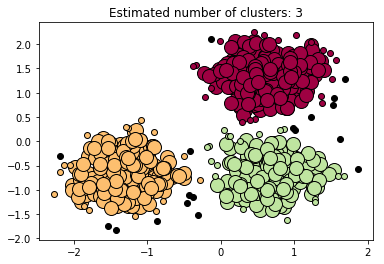

In [28]:

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

print(X.shape)
X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [29]:
alldf.size

422868